In [191]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Introduction

This notebook explores a (simulated) data set provided by Starbucks as part of a Udacity Data Science course. The original data consist of three data sets: (1) metadata on several promotional campaigns (offers); (2) basic sociodemographic data on users who were part of these campaigns; (3) a data set on user transactions and received or completed offers. Below, we will look at the basic characteristics of the data that are relevant to the analysis of the effectiveness of promotional campaigns summarized in a separate notebook.

# Exploring Data on Users

First, let's look at the dimensions of the data and missing observations. We can see that for some users, gender and income data are missing.

In [192]:
print("Total number of promotional campaigns: " + str(portfolio.shape[0]))
print("Total number of users: " + str(profile.shape[0]))

print("Missing data on users:")
profile.isna().sum()

print("Missing data on transactions/received offers:")
transcript.isna().sum()

Total number of promotional campaigns: 10
Total number of users: 17000
Missing data on users:
Missing data on transactions/received offers:


person    0
event     0
value     0
time      0
dtype: int64

Let's examine the user data in a bit more detail.

In [193]:
print("Gender composition of the sample:")
profile.gender.value_counts()

Gender composition of the sample:


M    8484
F    6129
O     212
Name: gender, dtype: int64

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'income'}>]], dtype=object)

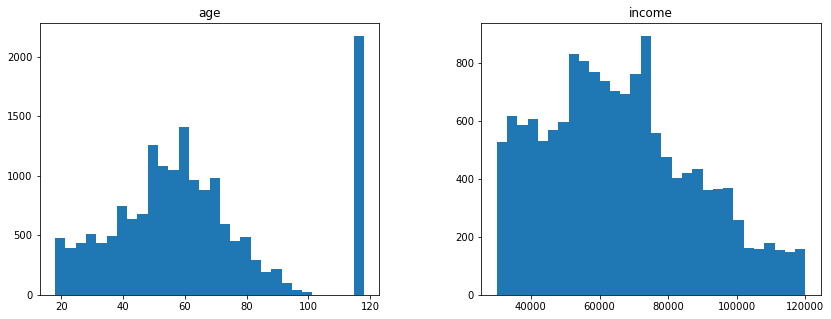

In [194]:
# histograms by age and income
profile[['age', 'income']].hist(grid=False, bins=30, figsize=(14, 5))

<AxesSubplot:title={'center':'Membership start, by month-year'}>

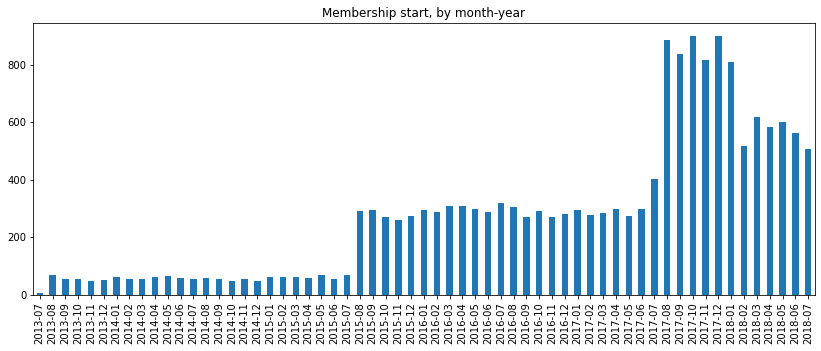

In [195]:
# the duration of membership, by year-month
profile['membership_month'] = pd.to_datetime(
    profile['became_member_on'], format="%Y%m%d").dt.to_period('M')
profile.groupby('membership_month').size().plot(kind='bar', grid=False, figsize=(14, 5), title='Membership start, by month-year', xlabel='')

There is a weird spike of customers whose age is around 120. Further examination shows that for all 2175 users with missing gender (and income), age is set to 118. This seems like a placeholder for a missing age. In the subsequent analysis, it would probably be wise to consider age also missing when its value is 118. 

In [196]:
profile[profile.gender.isna()].age.value_counts()

118    2175
Name: age, dtype: int64

# Exploring Data on Offers 

There are 4 BOGO offers, 2 informational offers, and 4 discounts. Rewards in BOGO and discount offers range from 2 to 10 dollars. Difficulty (minimum spending required to use an offer) ranges from 5 to 20 dollars.  

In [197]:
portfolio.drop(columns='id')

,reward,channels,difficulty,duration,offer_type
0,10,"[email, mobile, social]",10,7,bogo
1,10,"[web, email, mobile, social]",10,5,bogo
2,0,"[web, email, mobile]",0,4,informational
3,5,"[web, email, mobile]",5,7,bogo
4,5,"[web, email]",20,10,discount
5,3,"[web, email, mobile, social]",7,7,discount
6,2,"[web, email, mobile, social]",10,10,discount
7,0,"[email, mobile, social]",0,3,informational
8,5,"[web, email, mobile, social]",5,5,bogo
9,2,"[web, email, mobile]",10,7,discount


Here's a summary on the number of users who have received, viewed, and completed particular offers.

In [198]:
# expand the dict column in the transactions data
transcript = pd.concat([transcript, 
                        pd.DataFrame.from_records(transcript.value.tolist())],
                        axis=1)
transcript['offer_id'].fillna(transcript['offer id'], inplace=True)
transcript = transcript.drop(columns='offer id')

# merge with metadata on offers
transcript = pd.merge(transcript, 
                      portfolio.rename(
                          columns={'id': 'offer_id',
                                   'reward': 'offer_reward'}
                          ), how='left') 

# summary statistics on offers
offer_stats = transcript[
    transcript.event != 'transaction'
    ].groupby(
        by='event'
        ).offer_id.value_counts().reset_index(level=0).rename(
            columns={'offer_id': 'count'}
        ).reset_index(level=0).pivot(
            index='offer_id', columns='event', values='count').rename(
                columns=lambda s: s.replace('offer ', '')).reset_index(level=0)
offer_stats = pd.merge(offer_stats, portfolio.rename(
                          columns={'id': 'offer_id'}
                          ).drop(columns='channels'), how='left')
offer_stats = offer_stats[['offer_id', 'offer_type', 'reward', 'difficulty', 'duration', 'received', 'viewed', 'completed']]   
offer_stats.sort_values(by=['offer_type', 'reward']).reset_index(drop=True)

,offer_id,offer_type,reward,difficulty,duration,received,viewed,completed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,7677.0,4171.0,4354.0
1,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,7571.0,7264.0,4296.0
2,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,7593.0,7298.0,3331.0
3,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,7658.0,6716.0,3688.0
4,2906b810c7d4411798c6938adc9daaa5,discount,2,10,7,7632.0,4118.0,4017.0
5,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10,10,7597.0,7327.0,5317.0
6,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,7,7,7646.0,7337.0,5156.0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,20,10,7668.0,2663.0,3420.0
8,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,7617.0,4144.0,NaN
9,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,7618.0,6687.0,NaN


It's worth noting that each offer was received by approximately the same number of users, but the number of users who viewed and/or completed these offers varied substantially depending on the particular campaign. Naturally, more difficult offers (the ones that need more spending to redeem) were completed by smaller numbers of people. 

Notably, some offers were much more likely to be viewed by customers than other offers. See, e.g., the first two BOGO offers in the table. The second, despite being similar to the first one in its basic parameters, was viewed by a much larger number of users. The completion rate for these two offers, however, was almost the same. This may suggest that many customers become eligible for offers "automatically" by placing orders they would have placed in any case.  

One challenge with this data set is that almost every user in it has received some kind of a promotional offer, and many users have received multiple offers. As a result, in any comparison between users who have or have not received any particular offer, we have to keep in mind that either of these may have also received other offers. 

In [199]:
# number of offers per user
num_offers = transcript[transcript.event=='offer received'].groupby('person').size().reset_index(level=0)
print("Number of users who have not received any offers: " + str(transcript[~transcript.person.isin(num_offers.person.tolist())].person.shape[0]))

Number of users who have not received any offers: 20


In [200]:
# number of users by the number of offers they received
num_offers.columns = ['person', 'offers']
offers_per_user = num_offers.groupby('offers').size().reset_index(level=0)
offers_per_user.columns = ['offers_per_user', 'users']
offers_per_user

,offers_per_user,users
0,1,73
1,2,610
2,3,2325
3,4,4988
4,5,5931
5,6,3067


It is also worth noting that offers were issued/received at multiple points in time. The next table shows how many users received each particular offer at each point in time in hours. It is clear from the table that each offer was sent 6 times to an approximately the same number of users each time. The table also suggests that at each particular point in time, all 10 offers were sent simultaneously. 

In [201]:
offer_timing = transcript[
    transcript.event=='offer received'
    ].groupby(
        'offer_id'
        ).time.value_counts().reset_index(level=0).rename(
            columns={'time': 'users'}).reset_index(level=0).sort_values(
                ['offer_id', 'time']).pivot(
                    index='offer_id', columns='time', values='users')
offer_timing

time,0,168,336,408,504,576
offer_id,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,1297,1245,1322,1269,1258,1277
2298d6c36e964ae4a3e7e9706d1fb8c2,1221,1250,1301,1274,1286,1314
2906b810c7d4411798c6938adc9daaa5,1257,1270,1263,1335,1286,1221
3f207df678b143eea3cee63160fa8bed,1273,1266,1279,1275,1229,1295
4d5c57ea9a6940dd891ad53e9dbe8da0,1218,1240,1280,1308,1310,1237
5a8bc65990b245e5a138643cd4eb9837,1266,1270,1256,1293,1238,1295
9b98b8c7a33c4b65b9aebfe6a799e6d9,1245,1296,1275,1274,1261,1326
ae264e3637204a6fb9bb56bc8210ddfd,1292,1319,1245,1278,1248,1276
f19421c1d4aa40978ebb69ca19b0e20d,1263,1263,1247,1250,1305,1243


If we count the number of offers each user received in each time block, it becomes clear that every time the offers were sent, each offer was sent to only 1 user. That somewhat alleviates the challenge noted above, but there still remains an issue of previously received offers and how they might have affected one's interest in each new offer.

In [202]:
# number of offers per user per time block
num_offers_per_time_block = transcript[
    transcript.event=='offer received'
    ].groupby(['person', 'time']).size().reset_index(level=0)
num_offers_per_time_block.columns = ['person', 'offers']
print("Maximum number of offers per user per time block: " + str(num_offers_per_time_block.offers.max()))

Maximum number of offers per user per time block: 1


Moreover, it is possible that when one received a particular offer, other (previous) offers were still active for that person, depending on the duration of the previous offers. To check this, we will create a data frame of all days on which each offer was in effect for the users to whom it was sent. In other words, for each user, there will be a row on any given day since the beginning of the test when any particular offer was active.

In [203]:
# a list of time points when offers were sent
offer_reception_times = transcript[
    transcript.event=='offer received'
    ].time.unique().tolist()
# extract only received offers/drop other transactions
received_offers = transcript[transcript.event == 'offer received']

def extract_users_by_received_offer(offer, time_point):
    
    '''
    Create a data frame of users for which the offer was active, by day.
    
    Args:
        offer: offer id
        time_point: time at which the offer was sent
        
    Returns: data frame with all days on which offer was active for
    users to whom it was sent
    '''
    
    # list of users who received a particular offer
    user_list = received_offers[
        (received_offers.offer_id == offer) &
        (received_offers.time == time_point)
        ].person.tolist()
    
    # extract offer duration from portfolio
    offer_duration = portfolio[portfolio.id == offer].duration.item()
    
    # create a list of days on which the offer was active 
    # (counting from the beginning of the test)
    offer_days = list(range(int(time_point/24) + 1, 
                            int(time_point/24) + 1 + offer_duration,
                            1))
    
    # data frame with all users that received an offer;
    # includes all the days on which the offer was active for these users
    user_duration = [pd.DataFrame({
        'person': user_list, 
        'offer_id': [offer]*len(user_list),
        'day': [offer_day]*len(user_list), 
        'offer_active': [1]*len(user_list)
        }) for offer_day in offer_days]
    user_duration = pd.concat(user_duration)
    
    return user_duration

def create_offer_daily_data(offer):
    
    '''
    Create a data frame of users for which a particular offer was active, 
    by day, for all time points on which the offer was sent.
    
    Args:
        offer: offer id
        
    Returns: data frame with all days on which offer was active for
    users to whom it was sent, for all the times the offer was sent
    '''
    
    offer_active_by_time = [extract_users_by_received_offer(offer,
                                                            time_point) for
                            time_point in offer_reception_times]
    offer_active_by_time  = pd.concat(offer_active_by_time )
    return offer_active_by_time 
    
offers_active_by_day = [create_offer_daily_data(offer) for offer in
                        portfolio.id.tolist()]
offers_active_by_day = pd.concat(offers_active_by_day)

We can now use this data frame to check how many unique offers and how many offers in total were in effect for each user on any given day.

In [204]:
# number of unique offers active for each user on a given day
unique_offers_per_user = offers_active_by_day.groupby([
    'person', 'day'
    ]).offer_id.nunique()
    
# total number of offers active for each user on a given day
num_offers_per_user = offers_active_by_day.groupby([
    'person', 'day'
    ]).offer_active.sum()

We can now see that there were quite a few cases when a user on a given day had 2 or more active offers. (There were more cases when users had 2 or more offers in total than there were cases when users had 2 or more unique offers because some users may have been sent the same offer two weeks in a row.) Of course, even if multiple offers were active simultaneously, some users have not viewed all or some of these offers.

This suggests that the data-generating process was quite complex, and building a realistic causal model of this process would be difficult.

In [205]:
print('Number of user-days when more than 1 unique offer was active for particular users: ' + str(unique_offers_per_user[unique_offers_per_user > 1].sum()))
print('Number of user-days when only 1 unique offer was active for particular users: ' + str(unique_offers_per_user[unique_offers_per_user == 1].sum()))
print('Number of user-days when more than 1 offer in total was active for particular users: ' + str(num_offers_per_user[num_offers_per_user > 1].sum()))
print('Number of user-days when only 1 offer was active for particular users: ' + str(num_offers_per_user[num_offers_per_user == 1].sum()))


Number of user-days when more than 1 unique offer was active for particular users: 177502
Number of user-days when only 1 unique offer was active for particular users: 307406
Number of user-days when more than 1 offer in total was active for particular users: 198072
Number of user-days when only 1 offer was active for particular users: 298011
